In [43]:
import numpy as np 
import matplotlib.pyplot as plt
import io, pyopenlpt as lpt

redirector = lpt.PythonStreamRedirector()

import pybind11
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    print("⏭️ skipped this cell")
    # 什么都不执行，直接返回
    return

In [44]:
%%skip # skip this cell (comment this out if you want to run this cell)
# test bubble basic functions
import numpy as np
from scipy.io import loadmat

# read camera information
config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(config_file)
cam_list = basic_settings._cam_list

# load synthetic data
data   = loadmat('../../test/inputs/test_STB_Bubble/data.mat')
tracks = data['tracks']
r_mm   = data['r_mm']           # shape: (N, 2) -> [id, radius_mm]
img_bb_ref = data['b_ref']

# --- robust ID→radius lookup (avoid float==float pitfalls) ---
ids = r_mm[:, 0].astype(int)
rs  = r_mm[:, 1].astype(float)
id_to_r = dict(zip(ids, rs))

bb1    = tracks[0, :3]
id_bb1 = int(round(tracks[0, 4]))     # ensure integer id
r_bb1  = float(id_to_r[id_bb1])       # scalar, no DeprecationWarning

# build object (scalar radius!)
obj_bb1 = lpt.Bubble3D(lpt.Pt3D(float(bb1[0]), float(bb1[1]), float(bb1[2])), r_bb1)
print(obj_bb1._pt_center, obj_bb1._r3d)

# 2D radius
with lpt.PythonStreamRedirector():
    obj_bb1.projectObject2D(cam_list)

r_bb1_check = lpt.Bubble.calRadiusFromOneCam(cam_list[0], obj_bb1._pt_center, obj_bb1._obj2d_list[0]._r_px)
r_bb1_check2 = lpt.Bubble.calRadiusFromCams(cam_list, obj_bb1._pt_center, obj_bb1._obj2d_list)
print(r_bb1, r_bb1_check, r_bb1_check2)

lptimg_bb_ref = lpt.Image.from_numpy(img_bb_ref.astype(np.uint8))
d_b = max(1, int(round(float(obj_bb1._obj2d_list[0]._r_px) * 2.0)))
resizer = lpt.BubbleResize()
img1_bb1 = resizer.ResizeBubble(lptimg_bb_ref, d_b, cam_list[0]._max_intensity)

arr = np.array(img1_bb1.to_list(), dtype=np.uint8)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper")
plt.colorbar()
plt.title("Resized Bubble")
plt.show()


⏭️ skipped this cell


In [45]:
%%skip # skip this cell (comment this out if you want to run this cell)

# generate bubble synthetic image
# Generate synthetic bubble images (occlusion compositing)
# Inputs: tracks [x,y,z, frame_id, track_id], r_mm [track_id, radius_mm], img_bb_ref (template)
# Outputs:
#   ../../test/inputs/test_STB_Bubble/imgFile/cam{1..4}/img00000.tif
#   ../../test/inputs/test_STB_Bubble/imgFile/cam{1..4}ImageNames_python.txt

import os
import math
import numpy as np
from scipy.io import loadmat
from tifffile import imwrite

# ========= 路径 =========
ROOT = '../../test/inputs/test_STB_Bubble'
OUT_ROOT = os.path.join(ROOT, 'imgFile')
os.makedirs(OUT_ROOT, exist_ok=True)

# ========= 相机（均为 PINHOLE 且 active）=========
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(os.path.join(ROOT, 'config_python.txt'))
cam_list = basic_settings._cam_list
n_cam = len(cam_list)
assert n_cam >= 1, "No camera found."

# ========= 数据 =========
data = loadmat(os.path.join(ROOT, 'data.mat'))
tracks = data['tracks']          # [x,y,z, frame_id, track_id]
r_mm   = data['r_mm']            # [track_id, radius_mm]
img_bb_ref_np = data['b_ref']    # 模板 (2D)

# TrackID -> 半径(mm)
ids = r_mm[:, 0].astype(int)
rs  = r_mm[:, 1].astype(float)
id_to_r = dict(zip(ids, rs))

# 模板转 lpt.Image
lptimg_bb_ref = lpt.Image.from_numpy(img_bb_ref_np.astype(np.uint8))

# ========= 工具 =========
def frame_to_name(fid: int) -> str:
    return f"img{int(fid):05d}.tif"

def ensure_cam_dirs(out_root: str, n_cam: int):
    ds = []
    for i in range(n_cam):
        d = os.path.join(out_root, f"cam{i+1}")
        os.makedirs(d, exist_ok=True)
        ds.append(d)
    return ds

def proj_ok(o2d) -> bool:
    u = o2d._pt_center[0]
    v = o2d._pt_center[1]
    return np.isfinite(u) and np.isfinite(v)

def valid_r(r_px) -> bool:
    return np.isfinite(r_px) and (r_px > 0.25)

def get_RT_for_cam(cam):
    """Xc = R*Xw + T（PINHOLE）；从 pinhole_param 取 r_mtx/t_vec"""
    p = cam._pinhole_param
    R = np.array(p.r_mtx.to_list(), dtype=float).reshape(3, 3)
    T = np.array(p.t_vec.to_list(),  dtype=float).reshape(3)
    return R, T

def cam_depth_Zc(cam, Xw_xyz):
    """返回 Zc；系统朝 +Z 看 → Zc 越大越远"""
    R, T = get_RT_for_cam(cam)
    Xw = np.array(Xw_xyz, dtype=float)
    Xc = R @ Xw + T
    return float(Xc[2])

def paste_cover_masked(canvas: np.ndarray, patch: np.ndarray, mask: np.ndarray, cx: int, cy: int):
    """
    遮挡合成：只在 mask=True 且 patch>0 的位置覆盖；自动裁剪越界
    canvas/patch: uint8, HxW
    """
    H, W = canvas.shape
    ph, pw = patch.shape
    x0 = cx - pw // 2; y0 = cy - ph // 2
    x1 = x0 + pw;      y1 = y0 + ph

    sx0 = max(0, x0); sy0 = max(0, y0)
    sx1 = min(W, x1); sy1 = min(H, y1)
    if sx0 >= sx1 or sy0 >= sy1:
        return

    px0 = sx0 - x0; py0 = sy0 - y0
    px1 = px0 + (sx1 - sx0); py1 = py0 + (sy1 - sy0)

    pr  = patch[py0:py1, px0:px1]
    mr  = mask [py0:py1, px0:px1]
    cr  = canvas[sy0:sy1, sx0:sx1]

    use = mr & (pr > 0)
    cr[use] = pr[use]

# 圆形掩膜缓存
mask_cache = {}
def get_circular_mask(d_b: int, patch_np: np.ndarray) -> np.ndarray:
    """
    生成与 patch 同尺寸的布尔圆掩膜（半径 ~ d_b/2），裁掉方形角落
    """
    key = (int(d_b), tuple(patch_np.shape))
    m = mask_cache.get(key)
    if m is None:
        ph, pw = patch_np.shape
        r = 0.5 * min(int(d_b), ph, pw)
        cy = (ph - 1) / 2.0
        cx = (pw - 1) / 2.0
        yy, xx = np.ogrid[:ph, :pw]
        m = ((xx - cx) ** 2 + (yy - cy) ** 2) <= (r * r)
        mask_cache[key] = m
    return m

# ========= 输出 =========
cam_dirs  = ensure_cam_dirs(OUT_ROOT, n_cam)
cam_lists = [[] for _ in range(n_cam)]

img_sizes  = [(cam.getNRow(), cam.getNCol()) for cam in cam_list]
max_intens = [float(cam._max_intensity) for cam in cam_list]

resizer = lpt.BubbleResize()
# 不同相机（幅值）与直径的补丁缓存
patch_cache = {}  # key: (icam, diameter_px) -> np.uint8 patch

all_frames = np.unique(tracks[:, 3].astype(int))
print(f"Total frames: {len(all_frames)}, cameras: {n_cam}")

# ========= 主循环 =========
for fi, fid in enumerate(all_frames):
    # 每相机一张空画布
    canvases = [np.zeros(sz, dtype=np.uint8) for sz in img_sizes]
    rows_f = tracks[tracks[:, 3].astype(int) == int(fid), :]

    # 为每个相机收集绘制项：(Zc, u, v, patch_np, mask_np)
    drawlists = [[] for _ in range(n_cam)]

    if rows_f.size > 0:
        for row in rows_f:
            x = float(row[0]); y = float(row[1]); z = float(row[2])
            tid = int(round(row[4]))
            R3D = float(id_to_r.get(tid, 0.0))
            if not (R3D > 0.0 and math.isfinite(R3D)):
                continue

            obj = lpt.Bubble3D(lpt.Pt3D(x, y, z), R3D)
            with lpt.PythonStreamRedirector():
                obj.projectObject2D(cam_list)

            for icam, cam in enumerate(cam_list):
                o2d = obj._obj2d_list[icam]
                if not proj_ok(o2d):
                    continue
                r_px = float(o2d._r_px)
                if not valid_r(r_px):
                    continue

                u = int(round(o2d._pt_center[0]))
                v = int(round(o2d._pt_center[1]))
                d_b = max(1, int(round(2.0 * r_px)))  # 直径（像素）

                key = (icam, d_b)
                if key not in patch_cache:
                    patch_img = resizer.ResizeBubble(lptimg_bb_ref, d_b, max_intens[icam])
                    patch_np  = np.array(patch_img.to_list(), dtype=np.uint8)
                    patch_cache[key] = patch_np
                else:
                    patch_np = patch_cache[key]

                mask_np = get_circular_mask(d_b, patch_np)
                Zc = cam_depth_Zc(cam, (x, y, z))
                if not np.isfinite(Zc):
                    continue

                drawlists[icam].append((Zc, u, v, patch_np, mask_np))

    # 画家算法：相机朝 +Z → Zc 从大到小（先远后近）
    for icam in range(n_cam):
        for Zc, u, v, patch_np, mask_np in sorted(drawlists[icam], key=lambda t: t[0], reverse=True):
            paste_cover_masked(canvases[icam], patch_np, mask_np, u, v)

        fname = frame_to_name(fid)
        save_path = os.path.join(cam_dirs[icam], fname)
        imwrite(save_path, canvases[icam])

        # 清单写相对路径（与你示例一致）
        rel_path = os.path.join(OUT_ROOT, f"cam{icam+1}", fname)
        cam_lists[icam].append(rel_path)

    if (fi + 1) % 10 == 0 or fi == 0:
        print(f"[{fi+1}/{len(all_frames)}] frame {fid} done (occlusion, circular mask).")

# ========= 写清单 =========
for icam in range(n_cam):
    list_txt = os.path.join(OUT_ROOT, f"cam{icam+1}ImageNames_python.txt")
    with open(list_txt, 'w', encoding='utf-8') as f:
        for p in cam_lists[icam]:
            f.write(p.replace("\\", "/") + "\n")
    print(f"Wrote {list_txt} ({len(cam_lists[icam])} lines)")

⏭️ skipped this cell


In [46]:
config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(config_file)
cam_list = basic_settings._cam_list

from pprint import pprint

with lpt.PythonStreamRedirector():
    bb_cfg = lpt.BubbleConfig()
    bb_cfg.readConfig(basic_settings._object_config_paths[0], basic_settings)

# 子结构字段白名单
SUBFIELDS = {
    "IPRParam": [
        "n_cam_reduced", "n_loop_ipr", "n_loop_ipr_reduced", "n_obj2d_process_max"
    ],
    "PFParam": [
        "limit", "nx", "ny", "nz", "r",
        "nBin_x", "nBin_y", "nBin_z",
        "is_smooth", "sigma_x", "sigma_y", "sigma_z"
    ],
    "SMParam": [
        "match_cam_count", "idmap_cell_px", "tol_2d_px", "tol_3d_mm"
    ],
    "ShakeParam": [
        "_shake_width", "_n_shake_loop", "_thred_ghost", "_shakewidth_min", "_ratio_augimg"
    ],
    "STBParam": [
        "_radius_search_obj", "_n_initial_frames", "_radius_search_track"
    ],
}

# Config（派生 + 基类）的候选字段（存在就取）
CONFIG_CANDIDATES = [
    # BUbbleConfig 自身
    "_radius_min", "_radius_max", "_sense", "_bb_ref_img",
    # ObjectConfig 基类
    "_n_thread", "_stb_param", "_shake_param", "_pf_param", "_ipr_param", "_sm_param",
]

def _maybe_extract(obj):
    """递归展开已知的子结构；否则返回原值或字符串"""
    tname = type(obj).__name__
    if tname in SUBFIELDS:
        out = {}
        for name in SUBFIELDS[tname]:
            out[name] = getattr(obj, name)
        return out
    return obj  # 对未列白名单的类型（如 OTF）直接返回对象本身

def bubble_cfg_to_dict(bb_cfg):
    d = {}
    # 合并派生类 + 基类字段（存在就读）
    for name in CONFIG_CANDIDATES:
        if hasattr(bb_cfg, name):
            val = getattr(bb_cfg, name)
            d[name] = _maybe_extract(val)
    # kind 是只读属性
    d["kind"] = bb_cfg.kind
    return d

# 用法
pprint(bubble_cfg_to_dict(bb_cfg), sort_dicts=False, width=100)

{'_radius_min': 2,
 '_radius_max': 30,
 '_sense': 0.9,
 '_bb_ref_img': <pyopenlpt.BubbleRefImg object at 0x00000234AED6BDB0>,
 '_stb_param': {'_radius_search_obj': 0.4, '_n_initial_frames': 4, '_radius_search_track': 1.2},
 '_shake_param': {'_shake_width': 0.02,
                  '_n_shake_loop': 4,
                  '_thred_ghost': 0.1,
                  '_shakewidth_min': 0.001,
                  '_ratio_augimg': 2},
 '_pf_param': {'limit': <pyopenlpt.AxisLimit object at 0x00000234B244CE30>,
               'nx': 51,
               'ny': 51,
               'nz': 51,
               'r': 1.0,
               'nBin_x': 11,
               'nBin_y': 11,
               'nBin_z': 11,
               'is_smooth': True,
               'sigma_x': 1.0,
               'sigma_y': 1.0,
               'sigma_z': 1.0},
 '_ipr_param': {'n_cam_reduced': 1,
                'n_loop_ipr': 2,
                'n_loop_ipr_reduced': 1,
                'n_obj2d_process_max': 200000},
 '_sm_param': {'match_cam_co

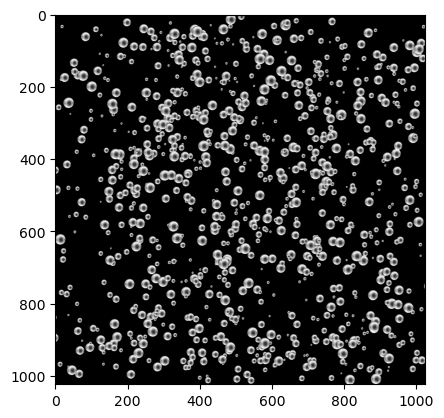

In [47]:
# create ImageIO instances for each image path
imgio_list = []
for path in basic_settings._image_file_paths:
    io = lpt.ImageIO()
    io.loadImgPath("", path)
    imgio_list.append(io)

num_cams = len(imgio_list)
frame_id = 0

image_list = []
for i in range(num_cams):
    image_list.append(imgio_list[i].loadImg(frame_id))

arr = np.array(image_list[0].to_list(), dtype=np.uint8)

plt.imshow(arr, cmap="gray")
plt.show()

Camera 0: found 839 objects.
Camera 1: found 843 objects.
Camera 2: found 794 objects.
Camera 3: found 805 objects.


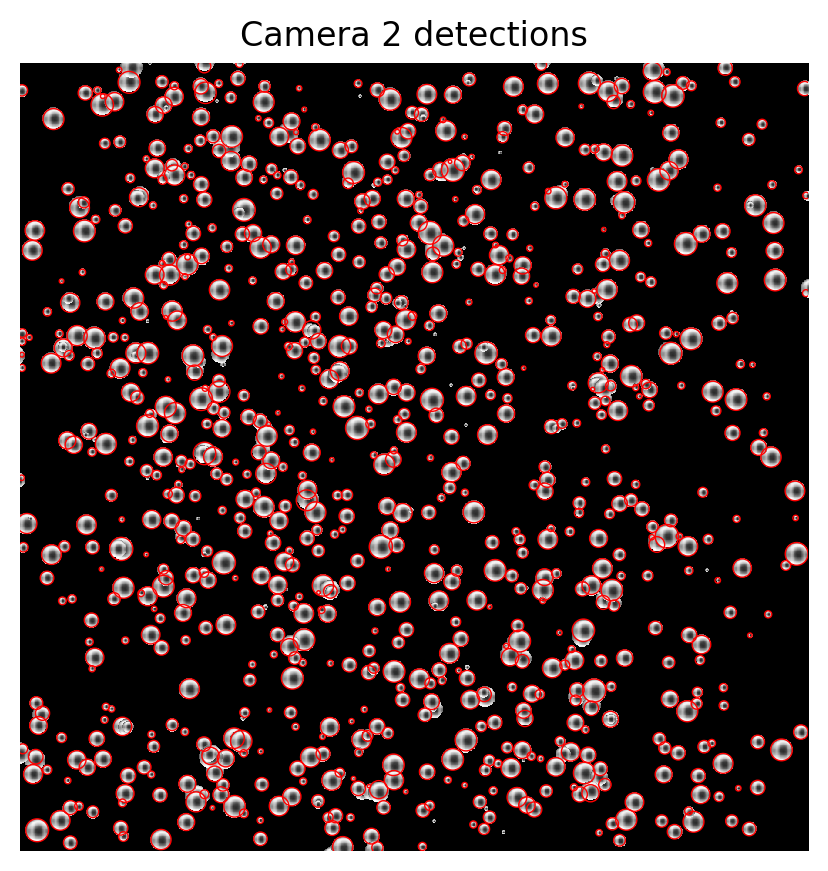

Camera 0: 839 objects, suspected duplicates within 2.0px = 0


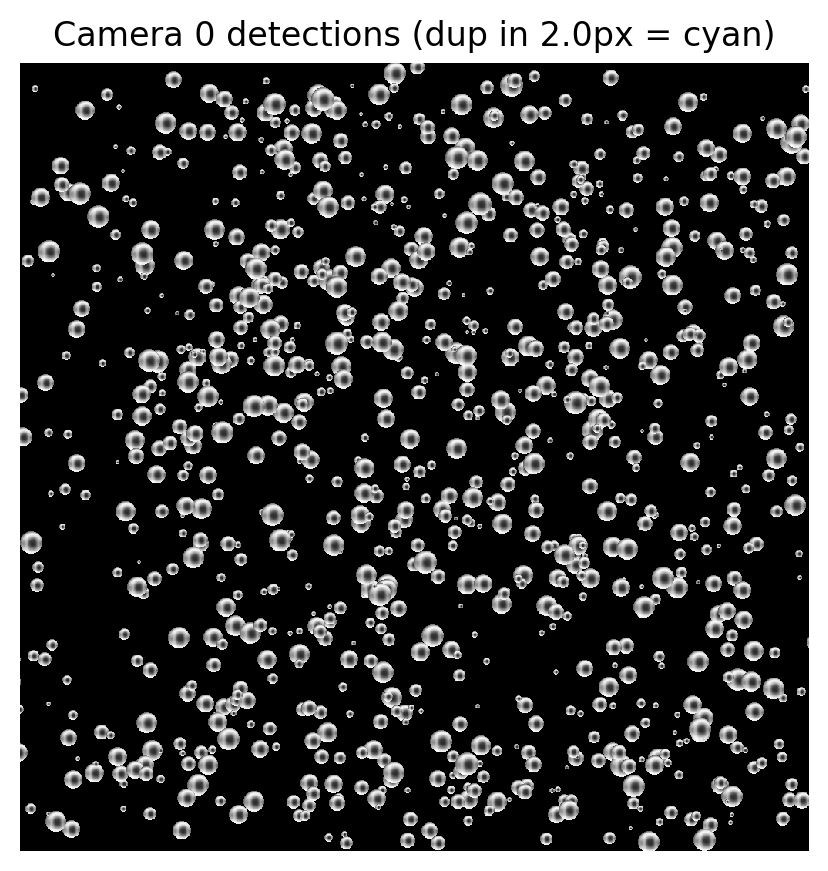

In [48]:
obj_finder = lpt.ObjectFinder2D()
n_cams = len(cam_list)
obj2d_list = []
for cam_id in range(n_cams):
    obj2ds = obj_finder.findObject2D(image_list[cam_id], bb_cfg)
    obj2d_list.append(obj2ds)
    print(f"Camera {cam_id}: found {len(obj2ds)} objects.")

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

img = np.array(image_list[1].to_list(), dtype=np.uint8)
points = obj2d_list[1]

xs = [float(p._pt_center[0]) for p in points]
ys = [float(p._pt_center[1]) for p in points]
rs = [float(p._r_px)        for p in points] 

h, w = img.shape[:2]
dpi = 200
figsize = (w / dpi, h / dpi)

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.imshow(img, cmap="gray", interpolation="none", origin="upper")

# 用 PatchCollection 一次性添加很多圆，效率更高
circles = [Circle((x, y), r) for x, y, r in zip(xs, ys, rs)]
pc = PatchCollection(
    circles,
    facecolor='none',       # 空心
    edgecolor='r',
    linewidths=0.5,
    antialiased=True
)
ax.add_collection(pc)

ax.set_title("Camera 2 detections")
ax.axis("off")
plt.show()

# test whether there are repeated points
# ---- 参数 ----
cam_id = 0
px_thresh = 2.0  # 判定重复的像素距离阈值

# ---- 取出该相机的图像与检测点 ----
img = np.array(image_list[cam_id].to_list(), dtype=np.uint8)
points = obj2d_list[cam_id]

xs = np.array([float(p._pt_center[0]) for p in points], dtype=float)
ys = np.array([float(p._pt_center[1]) for p in points], dtype=float)
rs = np.array([float(p._r_px)        for p in points], dtype=float)
centers = np.column_stack([xs, ys])
n = len(points)

# ---- 找到疑似重复点索引（任意邻居在阈值内即视为重复）----
dup_mask = np.zeros(n, dtype=bool)

try:
    # 优先使用 SciPy 加速（若可用）
    from scipy.spatial import cKDTree
    tree = cKDTree(centers)
    # 与自身比较，半径搜索；返回每个点的邻居索引列表
    neighs = tree.query_ball_tree(tree, r=px_thresh)
    for i, lst in enumerate(neighs):
        # 列表通常包含自身 i；只要存在别的 j ≠ i 即标记为重复
        if any(j != i for j in lst):
            dup_mask[i] = True
except Exception:
    # 纯 numpy 方案（O(N^2)），小样本足够快
    diff = centers[:, None, :] - centers[None, :, :]      # [n, n, 2]
    dist2 = np.sum(diff * diff, axis=-1)                  # [n, n]
    np.fill_diagonal(dist2, np.inf)                       # 排除自身
    dup_mask = (dist2 <= px_thresh * px_thresh).any(axis=1)

n_dup = int(dup_mask.sum())
print(f"Camera {cam_id}: {n} objects, suspected duplicates within {px_thresh}px = {n_dup}")

# （可选）打印前几个重复对以便人工核查
if n_dup > 0:
    # 简单找一些代表性配对
    shown = 0
    for i in np.where(dup_mask)[0]:
        # 找距离最近的一个邻居
        d2 = (centers - centers[i])**2
        d = np.sqrt(d2.sum(axis=1))
        d[i] = np.inf
        j = int(np.argmin(d))
        if d[j] <= px_thresh:
            print(f"  pair: ({i}, {j}) dist={d[j]:.3f}px  centers=({xs[i]:.1f},{ys[i]:.1f}) & ({xs[j]:.1f},{ys[j]:.1f})")
            shown += 1
        if shown >= 10:
            break

# ---- 绘图：普通点=红色，重复点=青色 ----
h, w = img.shape[:2]
dpi = 200
figsize = (w / dpi, h / dpi)

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.imshow(img, cmap="gray", interpolation="none", origin="upper")

# # 先画普通点
# circles_norm = [Circle((x, y), r) for x, y, r in zip(xs[~dup_mask], ys[~dup_mask], rs[~dup_mask])]
# pc_norm = PatchCollection(circles_norm, facecolor='none', edgecolor='r', linewidths=0.5, antialiased=True)
# ax.add_collection(pc_norm)

# 再画疑似重复点
circles_dup = [Circle((x, y), r) for x, y, r in zip(xs[dup_mask], ys[dup_mask], rs[dup_mask])]
pc_dup = PatchCollection(circles_dup, facecolor='none', edgecolor='c', linewidths=0.8, antialiased=True)
ax.add_collection(pc_dup)

ax.set_title(f"Camera {cam_id} detections (dup in {px_thresh}px = cyan)")
ax.axis("off")
plt.show()

Matched 401 3D objects.
True
(34, 34)


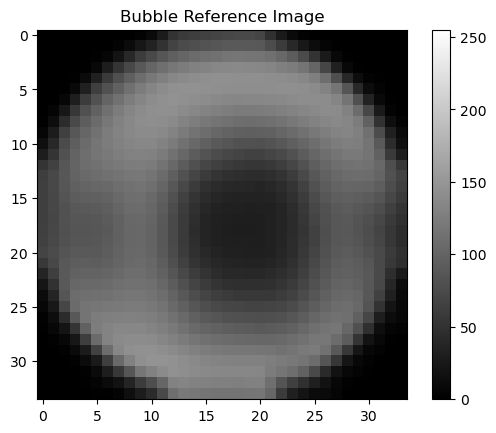

number of objects in GT: 1000, reconstructed: 401
real=398, ghosts=3


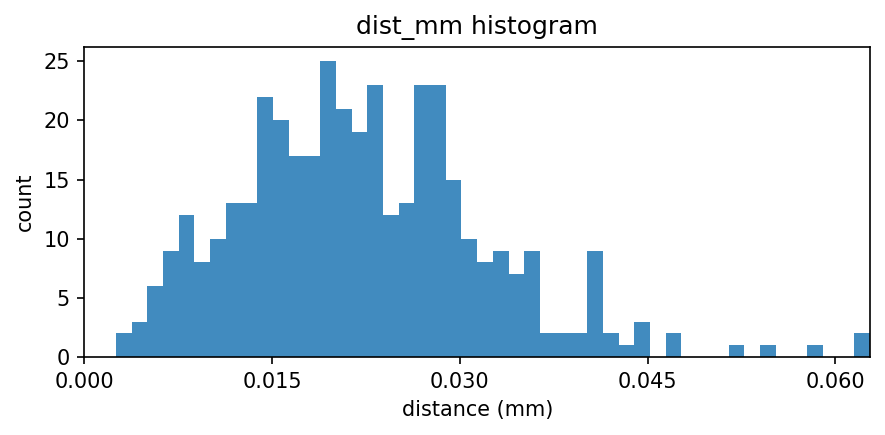

C:\Users\tan_s\AppData\Local\Temp\ipykernel_34848\2154397068.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', n_ghosts)   # 从 tab20 colormap 取 n_ghosts 种颜色


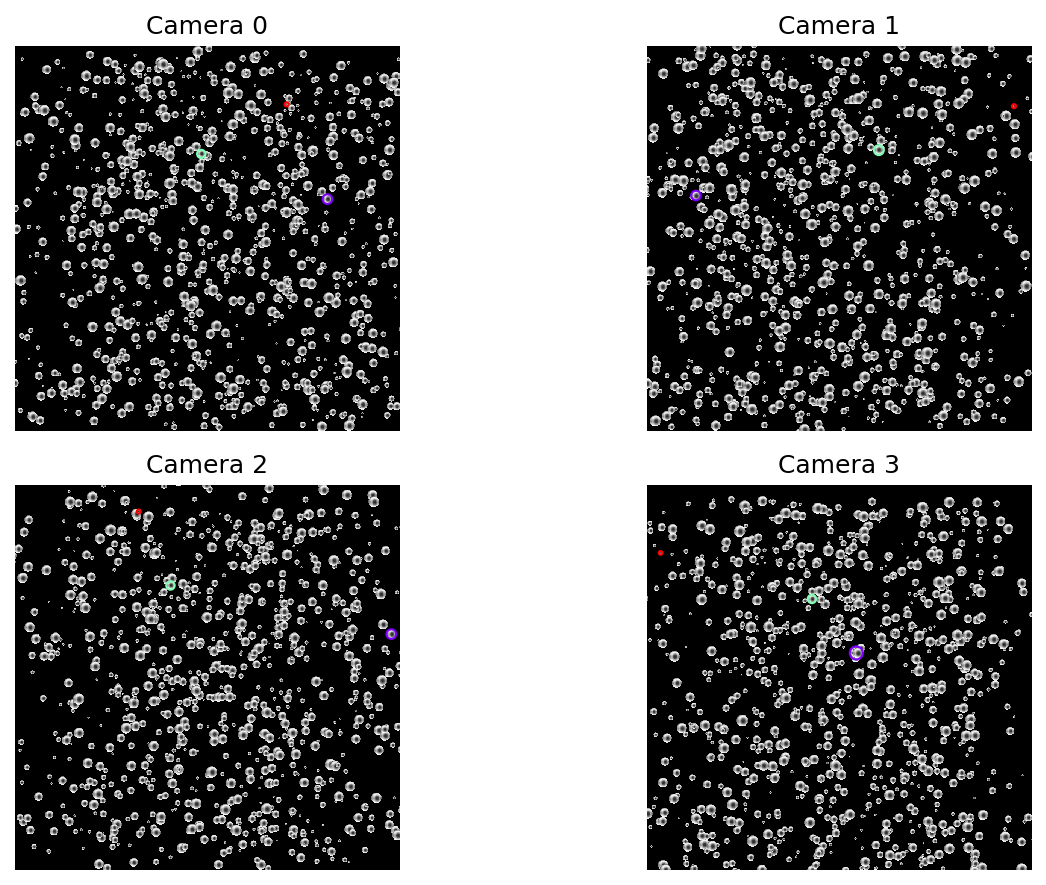

In [49]:
# test stereo matching
# to obtain bubble reference image, match camera number must equal to total camera number
bb_cfg._sm_param.match_cam_count = len(cam_list)
stereomath = lpt.StereoMatch(cam_list, obj2d_list, bb_cfg)
obj3d_list = stereomath.match()
print(f"Matched {len(obj3d_list)} 3D objects.")

# only match_cam_count cams have valid 2D projections
n_check = min(10, len(obj3d_list))

# for i, obj in enumerate(obj3d_list[:n_check]):
#     valid_cams = [c for c, o2d in enumerate(obj._obj2d_list) if o2d is not None]
#     n_valid = len(valid_cams)
#     print(f"obj#{i}: total cams={len(obj._obj2d_list)}, valid 2D={n_valid}, cams={valid_cams}")

# obtain bubble reference image
get_bb_img = bb_cfg._bb_ref_img.calBubbleRefImg(obj3d_list, obj2d_list, cam_list, image_list)
print(get_bb_img)

arr = np.array(bb_cfg._bb_ref_img[2].to_list(), dtype=np.uint8)
print(arr.shape)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper", vmin=0, vmax=255)
plt.colorbar()
plt.title("Bubble Reference Image")
plt.show()

from scipy.io import loadmat
import sys, pathlib
repo_root = pathlib.Path.cwd().parent          # for finding openLPT_utils
sys.path.insert(0, str(repo_root))
from openLPT_utils.ghost_eval import find_ghosts
# to check the quality of matched bubbles
data   = loadmat('../../test/inputs/test_STB_Bubble/data.mat')
tracks = data['tracks']
r_mm   = data['r_mm']           # shape: (N, 2) -> [id, radius_mm]

mask = tracks[:, 3] == 1  # get the first frame
pts_groundtrue = tracks[mask, :3].astype(np.float32)
ids_groundtrue = tracks[mask, 4].astype(int)
# 建立 id -> 半径 的映射
id2r = {int(i): float(r) for i, r in r_mm}
# 逐个取半径
r_groundtrue = np.array([id2r[i] for i in ids_groundtrue], dtype=np.float32)

print(f"number of objects in GT: {len(pts_groundtrue)}, reconstructed: {len(obj3d_list)}")
pts_reconstructed = np.array(
    [[obj._pt_center[0], obj._pt_center[1], obj._pt_center[2]] for obj in obj3d_list], 
    dtype=np.float32)

tol_mm = 2 * .04
cmp_st = find_ghosts(pts_groundtrue, pts_reconstructed, tol_mm, use_ckdtree=True)

print(f"real={len(cmp_st['matched_indices'])}, ghosts={len(cmp_st['ghost_indices'])}")
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

d = np.asarray(cmp_st['dist_mm'], float)
d = d[np.isfinite(d)]
if d.size == 0:
    print("dist_mm 为空")
else:
    p99 = np.percentile(d, 99)           # 只看前 99%，避免长尾挤压
    xmin, xmax = 0.0, p99
    bin_count = 50                       # 想更平滑就调大/调小

    fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
    ax.hist(d, bins=bin_count, range=(xmin, xmax), density=False, alpha=0.85)
    if 'tol_mm' in globals():
        ax.axvline(float(tol_mm), ls='--')
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # 一位小数
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))          # 控制刻度数量
    ax.set_xlabel('distance (mm)')
    ax.set_ylabel('count')
    ax.set_title('dist_mm histogram')
    plt.tight_layout(); plt.show()

from matplotlib.patches import Circle
import matplotlib.cm as cm

def show_ghosts_on_4cams(image_list, obj3d_list, ghost_indices, cam_ids=(0,1,2,3)):
    """在多相机图上圈出 ghost 对象，每个 ghost 用不同颜色。"""
    n_ghosts = len(ghost_indices)
    cmap = cm.get_cmap('rainbow', n_ghosts)   # 从 tab20 colormap 取 n_ghosts 种颜色

    # ---- 画图 ----
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=150)
    axs = axs.ravel()
    for ax, cam in zip(axs, cam_ids):
        img = np.array(image_list[cam].to_list(), dtype=np.uint8)
        ax.imshow(img, cmap="gray", interpolation="none", origin="upper")

        # 遍历每个 ghost
        for gi, idx in enumerate(ghost_indices):
            try:
                o2d = obj3d_list[idx]._obj2d_list[cam]
                x, y = float(o2d._pt_center[0]), float(o2d._pt_center[1])
                r = float(getattr(o2d, "_r_px", 3.0))
                if np.isfinite(x) and np.isfinite(y) and r > 0:
                    color = cmap(gi)  # 该 ghost 的唯一颜色
                    circ = Circle((x, y), r, fill=False, edgecolor=color, linewidth=1.0)
                    ax.add_patch(circ)
                    # ax.plot(x, y, '.', color=color, ms=5)
            except Exception:
                # 该相机上可能没有该 ghost 的2D投影
                pass

        ax.set_title(f"Camera {cam}")
        ax.axis("off")

    fig.tight_layout()
    plt.show()

show_ghosts_on_4cams(image_list, obj3d_list, cmp_st['ghost_indices'], cam_ids=(0,1,2,3))

CameraType.PINHOLE
ghost: 0 repeated: 0
[0.027317051207972103, 0.030429630359757636, 0.030535167167058647]
mean of scores: 0.027428750890486325
minimum of ghost scores: 0.027317051207972103


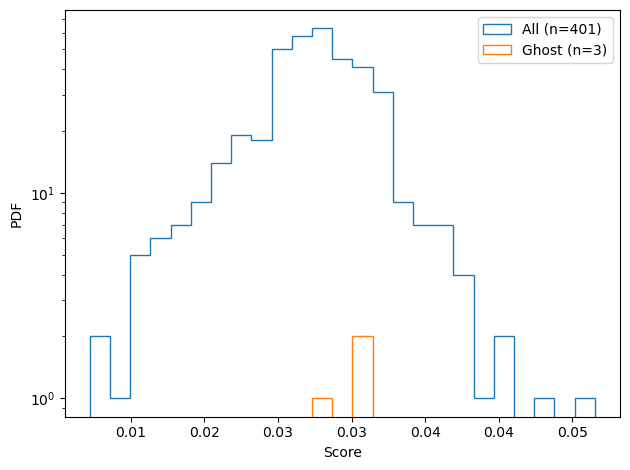

In [50]:
shaker = lpt.Shake(cam_list, bb_cfg)
print(shaker.cams[0]._type)

flags, obj3d_list_shaked = shaker.runShake(obj3d_list, image_list)
arr = np.asarray([int(f) for f in flags])  
n_ghost    = int(np.count_nonzero(arr & int(lpt.ObjFlag.Ghost)))
n_repeated = int(np.count_nonzero(arr & int(lpt.ObjFlag.Repeated)))
print("ghost:", n_ghost, "repeated:", n_repeated)

score_list = shaker.score_list
ghost_score = [score_list[i] for i in cmp_st['ghost_indices']]
print(ghost_score)

# plot PDF of score list and ghost score
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

scores = np.asarray(score_list, dtype=float)
print("mean of scores:", np.mean(scores))

print("minimum of ghost scores:", np.min(ghost_score))
gi = np.asarray(cmp_st['ghost_indices'])

# If ghost_indices is a boolean mask, convert to integer indices
if gi.dtype == bool:
    gi = np.flatnonzero(gi)

ghost_scores = scores[gi] if gi.size else np.array([])

# Freedman–Diaconis bins (robust, shared for both PDFs)
def fd_bins(x):
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 10
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * iqr * (x.size ** (-1/3))
    if bw <= 0:
        return 10
    return max(10, int(np.ceil((x.max() - x.min()) / bw)))

bins = fd_bins(scores)
pdf_all, edges = np.histogram(scores, bins=bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

plt.figure()
plt.hist(scores,bins=edges, density=False, histtype='step', label=f'All (n={scores.size})')

if ghost_scores.size:
    plt.hist(ghost_scores, bins=edges, density=False, histtype='step', label=f'Ghost (n={ghost_scores.size})')

ax = plt.gca()
ax.set_yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Score')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()
plt.show()


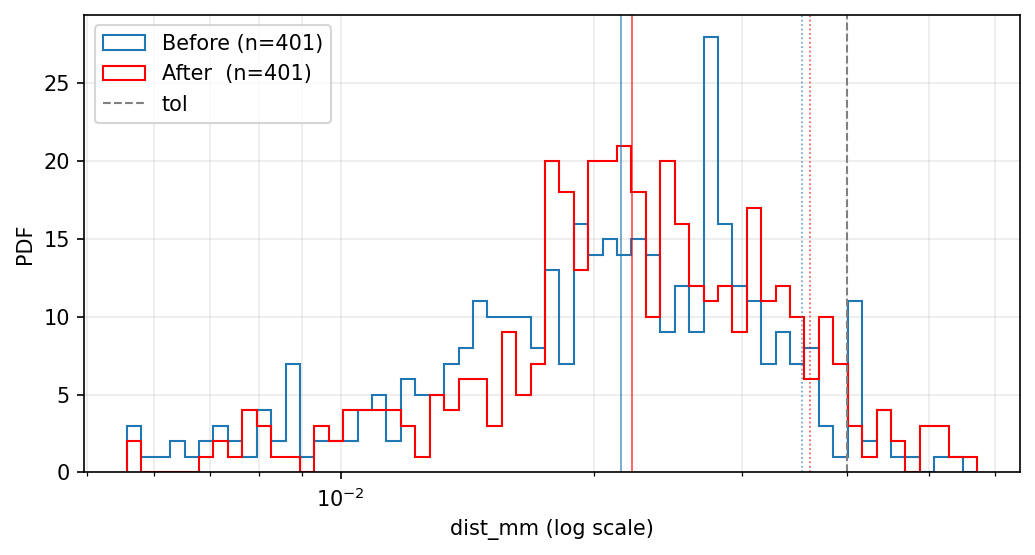

median:  before=0.0215 mm  ->  after=0.0222 mm  (+3.0%)
P90:     before=0.0353 mm ->  after=0.0361 mm (+2.3%)


In [51]:
# plot the position uncertianty after shaking
pts_shaked = np.array(
    [[obj._pt_center[0], obj._pt_center[1], obj._pt_center[2]] for obj in obj3d_list_shaked], 
    dtype=np.float32)
tol_mm = 1 * .04
cmp_shake = find_ghosts(pts_groundtrue, pts_shaked, tol_mm, use_ckdtree=True)

def clean_pos(x):
    x = np.asarray(x, float).ravel()
    return x[np.isfinite(x) & (x > 0.0)]  # log 轴不能有 <=0

d0 = clean_pos(cmp_st['dist_mm'])        # before shake
d1 = clean_pos(cmp_shake['dist_mm'])  # after  shake
if d0.size == 0 or d1.size == 0:
    print(f"Empty dist_mm: before={d0.size}, after={d1.size}")
else:
    # shared log-spaced bins on a robust range (1–99 percentile of both)
    all_pos = np.concatenate([d0, d1])
    lo = np.percentile(all_pos, 1)
    hi = np.percentile(all_pos, 99)
    lo = max(lo, np.min(all_pos))     # guard
    edges = np.logspace(np.log10(lo), np.log10(hi), 60)

    fig, ax = plt.subplots(figsize=(7, 3.8), dpi=150)
    ax.hist(d0, bins=edges, density=False, histtype='step', label=f'Before (n={d0.size})')
    ax.hist(d1, bins=edges, density=False, color = 'red', histtype='step', label=f'After  (n={d1.size})')

    ax.set_xscale('log')
    ax.set_xlabel('dist_mm (log scale)')
    ax.set_ylabel('PDF')

    # Reference lines: tolerance, medians, P90
    if 'tol_mm' in globals() and tol_mm and tol_mm > 0:
        ax.axvline(float(tol_mm), color='gray', ls='--', lw=1, label='tol')

    m0, m1 = np.median(d0), np.median(d1)
    p90_0, p90_1 = np.percentile(d0, 90), np.percentile(d1, 90)
    ax.axvline(m0,  ls='-',  lw=0.8, alpha=0.7)
    ax.axvline(m1,  ls='-',  color = 'red', lw=0.8, alpha=0.7)
    ax.axvline(p90_0, ls=':', lw=0.8, alpha=0.7)
    ax.axvline(p90_1, ls=':', color = 'red', lw=0.8, alpha=0.7)

    ax.legend()
    ax.grid(True, which='both', alpha=0.25)
    plt.tight_layout()
    plt.show()

    print(f"median:  before={m0:.3g} mm  ->  after={m1:.3g} mm  ({(m1/m0-1)*100:+.1f}%)")
    print(f"P90:     before={p90_0:.3g} mm ->  after={p90_1:.3g} mm ({(p90_1/p90_0-1)*100:+.1f}%)")

Worst-matched object index = 189 | reconstruction error distance (mm) = 0.03994786456949123
Error before Shake (mm) = 0.02769890069006038 | Error after Shake (mm) = 0.03994786456949123
3D center before Shake = <Pt3D (9.587394,1.870494,18.944227)> | after Shake = <Pt3D (9.602393,1.897025,18.946727)> | ground truth = <Pt3D (9.611080,1.860040,18.934381)>


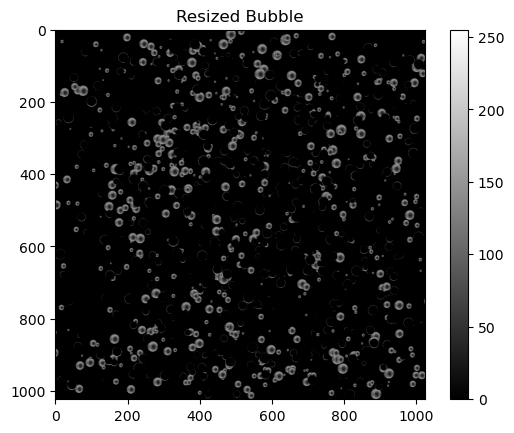

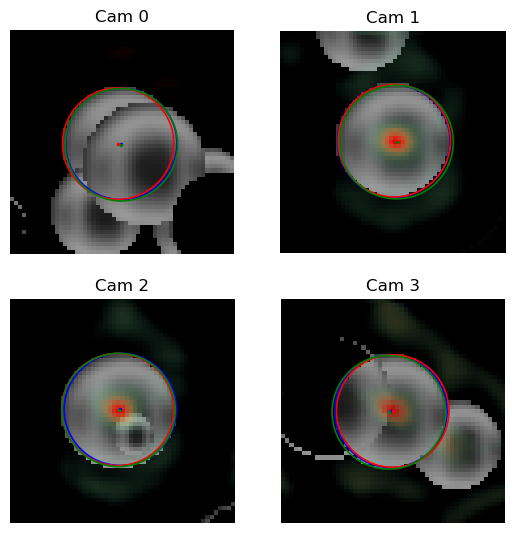

In [ ]:
# test shake
real_obj_index = cmp_shake["matched_indices"]
obj_ind = real_obj_index[int(np.argmax(cmp_shake["dist_mm"][real_obj_index]))]
error_pos = cmp_shake["dist_mm"][obj_ind]
print("Worst-matched object index =", obj_ind, 
      "| reconstruction error distance (mm) =", error_pos)

pt_gt = pts_groundtrue[cmp_shake["rec_to_gt"][obj_ind]]
r_gt = r_groundtrue[cmp_shake["rec_to_gt"][obj_ind]]
obj_gt = lpt.Bubble3D(lpt.Pt3D(pt_gt[0], pt_gt[1], pt_gt[2]), r_gt)
obj_gt.projectObject2D(cam_list)

e_bf = cmp_st["dist_mm"][obj_ind]
e_af = cmp_shake["dist_mm"][obj_ind]
print("Error before Shake (mm) =", e_bf, 
      "| Error after Shake (mm) =", e_af)
obj_bf = obj3d_list[obj_ind]
obj_af = obj3d_list_shaked[obj_ind]
print("3D center before Shake =", obj_bf._pt_center,
      "| after Shake =", obj_af._pt_center,
      "| ground truth =", obj_gt._pt_center)

for obj in obj3d_list:
    obj.projectObject2D(cam_list)

with lpt.PythonStreamRedirector():
    shaker.calResidueImage(obj3d_list, image_list)

img_res_1 = np.array(shaker.img_res_list[0].to_list(), dtype=np.int16)
img_res_1[img_res_1 < 0] = 0
arr = np.array(img_res_1, dtype=np.uint8)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper", vmin=0, vmax=255)
plt.colorbar()
plt.title("Resized Bubble")
plt.show()

roi_all = shaker.buildROIInfo(obj_bf, image_list)

n_cam = len(image_list)
cols = min(2, n_cam)
rows = int(np.ceil(n_cam / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))

# 让 axes 索引安全（兼容 1x1 / 1xn / nx1）
def get_ax(axes, r, c):
    if rows == 1 and cols == 1:
        return axes
    elif rows == 1:
        return axes[c]
    elif cols == 1:
        return axes[r]
    else:
        return axes[r, c]

step = 1
gamma = 1.2  # alpha 映射幂次，>1 更突出高相关

resizer = lpt.BubbleResize()

for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)
    aug_img = roi_all[k].getAugImg()
    aug_img = np.array(aug_img.to_list(), dtype = np.uint8)
    ax.imshow(aug_img, cmap="gray", interpolation="nearest", origin="upper", vmin=0, vmax=255)
    ax.set_title(f"Cam {k}")
    ax.set_axis_off()

    roi = roi_all[k]
    rmin, rmax = roi.ROI_range.row_min, roi.ROI_range.row_max
    cmin, cmax = roi.ROI_range.col_min, roi.ROI_range.col_max
    # 画 before / after / GT 的 2D 点（坐标要减 ROI 偏移）
    x_bf = obj_bf._obj2d_list[k]._pt_center[0] 
    y_bf = obj_bf._obj2d_list[k]._pt_center[1]
    r_bf = obj_bf._obj2d_list[k]._r_px
    x_af = obj_af._obj2d_list[k]._pt_center[0]
    y_af = obj_af._obj2d_list[k]._pt_center[1] 
    r_af = obj_af._obj2d_list[k]._r_px
    x_gt = obj_gt._obj2d_list[k]._pt_center[0] 
    y_gt = obj_gt._obj2d_list[k]._pt_center[1]
    r_gt = obj_gt._obj2d_list[k]._r_px

    circ_bf = Circle((x_bf - cmin, y_bf - rmin), r_bf, fill=False, edgecolor="blue",  linewidth=1.2, label="before")
    circ_af = Circle((x_af - cmin, y_af - rmin), r_af, fill=False, edgecolor="red",   linewidth=1.2, label="after")
    circ_gt = Circle((x_gt - cmin, y_gt - rmin), r_gt, fill=False, edgecolor="green", linewidth=1.2, label="ground truth")

    ax.add_patch(circ_bf)
    ax.add_patch(circ_af)
    ax.add_patch(circ_gt)

    ax.plot(x_bf - cmin, y_bf - rmin, ".", color="blue",  ms=3)
    ax.plot(x_af - cmin, y_af - rmin, ".", color="red",   ms=3)
    ax.plot(x_gt - cmin, y_gt - rmin, ".", color="green", ms=3)

    d_k = int(obj_bf._obj2d_list[k]._r_px * 2 + 1)
    ref_k = resizer.ResizeBubble(bb_cfg._bb_ref_img[k], d_k, cam_list[k]._max_intensity)
    H, W = aug_img.shape[:2]
    corr_map = np.zeros((H, W), dtype=np.float32)
    rmin, rmax = roi.ROI_range.row_min, roi.ROI_range.row_max
    cmin, cmax = roi.ROI_range.col_min, roi.ROI_range.col_max

    for yy in range(0, H, step):
        gy = int(rmin + yy)        # 全图坐标 y
        for xx in range(0, W, step):
            gx = int(cmin + xx)    # 全图坐标 x
            v = shaker.strategy.getImgCorr(roi, gx, gy, ref_k)
            # 兼容返回类型：标量或含标量的对象
            val = float(v)
            corr_map[yy, xx] = val
    
    alpha = np.clip(corr_map, 0, 1) ** gamma
    im = ax.imshow(corr_map, cmap="rainbow", interpolation="nearest", origin="upper", alpha=alpha)



In [ ]:
import pyopenlpt as lpt

config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
with lpt.PythonStreamRedirector():
    lpt.run(config_file)

**************
OpenLPT start!
**************

Initial phase at frame 0
START IPR...
Full cameras
Combination 0 cams=[0, 1, 2, 3]
		2D detections per active camera: 691  676  667  674   (0.44 s)
		Matched 298 objects. ( 2D tol: 2.00, t:0.01 s)	Obtained bubble reference image!	After shaking: 298 objects remain. (1.16 s)
	LOOP=0: TOTAL OBJECTS = 298
		2D detections per active camera: 428  417  392  419   (0.42 s)
		Matched 55 objects. ( 2D tol: 3.00, t:0.00 s)	After shaking: 55 objects remain. (0.42 s)
	LOOP=1: TOTAL OBJECTS = 353
Reduced cameras
Combination 0 cams=[0, 1, 2]
		2D detections per active camera: 385  347  365   (0.39 s)
		Matched 73 objects. ( 2D tol: 2.00, t:0.00 s)	After shaking: 73 objects remain. (0.39 s)
	LOOP=0: TOTAL OBJECTS = 426
Combination 1 cams=[0, 1, 3]
		2D detections per active camera: 314  349  294   (0.38 s)
		Matched 81 objects. ( 2D tol: 2.00, t:0.00 s)	After shaking: 81 objects remain. (0.41 s)
	LOOP=0: TOTAL OBJECTS = 507
Combination 2 cams=[0, 2, 3]
		2